In [110]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [111]:
c = MongoClient("100.89.103.30:27017", 27017)
db = c["stockDB"]
industry = db.industries
eodPrices = db.eodPrices

In [112]:
nganhangID = industry.find_one({"name": "Ngân hàng"}, {"_id": 1})["_id"]
nganhang_eodPrices = eodPrices.find({"industryId": nganhangID})
nganhang_df = pd.DataFrame(nganhang_eodPrices)
nganhang_df['date'] = pd.to_datetime(nganhang_df['date']).dt.strftime("%Y-%m-%d")
nganhang_df = nganhang_df[["date", "close", "open", "high", "low", "change", "percent_change"]].groupby('date').mean().reset_index()

In [113]:
nganhang_df["smooth_close"] = savgol_filter(nganhang_df["close"], 25, 3)
nganhang_df = nganhang_df[["date", "close", "smooth_close"]]

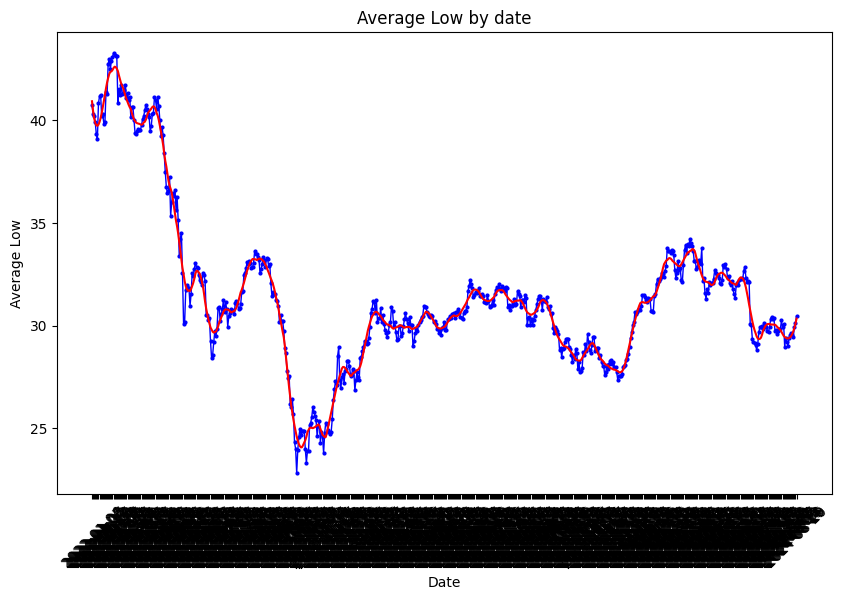

In [114]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nganhang_df['date'], nganhang_df['close'], marker='o', linestyle='-', color='blue', ms=2, linewidth=1)
plt.plot(nganhang_df['date'], nganhang_df["smooth_close"], linestyle='-', color='red', ms=1.2)
plt.title('Average Low by date')
plt.xlabel('Date')
plt.ylabel('Average Low')
# plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Show the plot
plt.show()

In [115]:
nganhang_df["Near"] = 0.0
nganhang_df["Mid"] = 0.0
nganhang_df["Far"] = 0.0

for i in range(len(nganhang_df)-30):
    nganhang_df.loc[i, "Near"] = 0 if nganhang_df.loc[i+1, "smooth_close"] - nganhang_df.loc[i, "smooth_close"] < 0 else 1
    nganhang_df.loc[i, "Mid"] = 0 if nganhang_df.loc[i+7, "smooth_close"] - nganhang_df.loc[i, "smooth_close"] < 0 else 1
    nganhang_df.loc[i, "Far"] = 0 if nganhang_df.loc[i+30, "smooth_close"] - nganhang_df.loc[i, "smooth_close"] < 0 else 1

nganhang_df.rename(columns={"date": "Date"}, inplace=True)

In [116]:
articles_data = pd.read_csv("../../data/raw/doanh_nghiep(1).csv")[["Published_Date", "Title", "Text"]].dropna()
articles_data["Published_Date"] = pd.to_datetime(articles_data["Published_Date"]).dt.strftime("%Y-%m-%d")
articles_data.rename(columns={"Published_Date": "Date"}, inplace=True)
articles_data.sort_values(by = 'Date', inplace=True)
articles_data.reset_index(inplace = True)
articles_data = articles_data.drop("index", axis=1)
articles_data

,Date,Title,Text
0,2022-03-02,Novaland thông qua kế hoạch góp vốn gần 5.900 ...,CTCP Tập đoàn Đầu tư Địa ốc No Va – Novaland (...
1,2022-03-02,"Lỗ 2 năm liên tiếp do dịch, Nasco tổn thất thê...",CTCP Dịch vụ hàng không sân bay Nội Bài (Nasco...
2,2022-03-02,Truyền hình K+ tiếp tục phát sóng Ngoại hạng A...,Sự kiện đánh dấu 15 năm liên tiếp K+ mang giải...
3,2022-03-02,"FLC, Bamboo Airways ""bắt tay"" chiến lược nhiều...",Ngay sau chuyến bay thẳng thường lệ Việt – Đức...
4,2022-03-02,"Pharmacity bán thuốc điều trị Covid-19, cam kế...",Hơn 800 nhà thuốc Pharmacity trên toàn quốc ch...
...,...,...,...
14556,2024-08-08,Nhà máy tại Hà Nam mở ra chương mới cho sự phá...,"Sáng 3/8, PepsiCo Foods Việt Nam khởi công xây..."
14557,2024-08-09,"3 ""đại gia"" xăng dầu nào vừa bị Bộ Công Thương...","Tổng cục Quản lý thị trường (QLTT, Bộ Công Thư..."
14558,2024-08-09,Bao bì giấy công nghệ cao cho ngành F&B: Không...,Rào cản để trở thành nhà cung cấp bao bì giấy ...
14559,2024-08-09,"Mixue ""hốt bạc"" tại thị trường Việt với 1.000 ...",Mixue là tên thương hiệu đồ uống đang trở nên ...


In [117]:
title_data = articles_data.groupby('Date')["Title"].apply(', '.join).reset_index()
document_data = articles_data.groupby('Date')["Text"].apply(', '.join).reset_index()

labeled = pd.merge(pd.concat((title_data, document_data['Text']), axis=1), 
                    nganhang_df[["Date", "Near", "Mid", "Far"]], on='Date', how='left').dropna()
labeled = labeled[labeled['Date'] <= "2024-07-01"]
labeled['Score'] = labeled['Near'] + labeled['Mid'] * 2 + labeled['Far'] * 3

labeled['Potential'] = None
for i in range (len(labeled)):
    if labeled.iloc[i,-2] < 2:
        labeled.iloc[i,-1] = 'Low'
    else:
        labeled.iloc[i,-1] = 'High'
# labeled.to_csv("../../data/processed/labeled_data.csv")

,Date,Title,Text,Near,Mid,Far,Score,Potential
0,2022-03-02,Novaland thông qua kế hoạch góp vốn gần 5.900 ...,CTCP Tập đoàn Đầu tư Địa ốc No Va – Novaland (...,0.0,0.0,0.0,0.0,Low
1,2022-03-03,"HAGL tiếp tục bán ra 25,4 triệu cổ phiếu HAGL ...","Hoàng Anh Gia Lai (HAGL, HAG) tiếp tục bán ra ...",0.0,0.0,0.0,0.0,Low
2,2022-03-04,[Làm giàu tuổi 20] Từ chuyên gia tài chính trở...,Tôi tên là Đặng Nguyên Cường. Năm 20 tuổi tôi ...,0.0,0.0,0.0,0.0,Low
5,2022-03-07,Tracodi (TCD) tiếp tục phát hành cổ phiếu tỷ l...,"Trong buổi gặp gỡ, ông Nguyễn Thanh Hùng, Phó ...",0.0,0.0,0.0,0.0,Low
6,2022-03-08,"Du lịch nội địa khởi sắc sau 'kỳ nghỉ' dài, do...","Tết Nguyên Đán dài ngày và chính sách mở cửa, ...",0.0,0.0,0.0,0.0,Low
...,...,...,...,...,...,...,...,...
846,2024-06-25,"Data vô vàn, sẵn sàng tận hưởng EURO 2024 cùng...",Sau 3 năm vắng bóng kể từ đại dịch Covid năm 2...,0.0,0.0,0.0,0.0,Low
847,2024-06-26,Bảo Việt dự kiến chi trả cổ tức năm 2023 bằng ...,Tập đoàn Bảo Việt (mã chứng khoán BVH) vừa dự ...,0.0,0.0,0.0,0.0,Low
848,2024-06-27,Tập đoàn Hoa Sen và SP Group ký kết hợp tác ch...,Xác định phát triển bền vững phải gắn liền với...,0.0,1.0,0.0,2.0,High
849,2024-06-28,"Ba tuyến cáp quang biển cùng gặp sự cố, lối đi...","3/5 tuyến cáp quang gặp sự cố, nhiều doanh ngh...",0.0,1.0,0.0,2.0,High
